# LCLS Cu Injector Surrogate Model  (up to OTR2)

predict $\epsilon_x$, $\epsilon_y$, $\sigma_x$, $\sigma_y$, $\sigma_z$
from NN trained on IMPACT-T simulations


# Links to Sections

* [Initial model info](#init)

* [Build model functions](#build)

* [Model predict with simulation units](#predict)

* [Model predict with machine units](#predict_machine)

* [Model comparison with sim scans](#scan)

* [Model comparison with a corrplot](#meas)



# Imports

In [158]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Activation, GaussianNoise, Reshape,  Conv2D, UpSampling2D
from tensorflow.keras import regularizers, datasets, layers, models
from tensorflow.keras.losses import mse 
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import time
import sys, os
import pickle as pick
import pandas as pd
import json
import array
import random
from math import sqrt
import pickle

from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler

import numdifftools as nd

<a id="init"></a>
# Initial Info

### Loading basic model info
todo - put into config file

In [159]:
PATH = ''
NAME = 'v3b_cnsga_'
screen ='OTR2'

In [160]:
with open(PATH+NAME+screen+'_list_dict.json') as json_file:
    json_names = json.load(json_file)
    
#inputs and outputs in raw data
output_names=json_names['out_'+screen+'_vars']

input_names = json_names['input_vars']

In [161]:
#inputs and outputs model is  trained on
model_in_list = input_names
model_out_list =['sigma_x','sigma_y','sigma_z','norm_emit_x', 'norm_emit_y']

#dictionary of location of variables in array
loc_in = {model_in_list[i]: np.arange(0,len(model_in_list))[i] for i in range(len(model_in_list))} 
loc_out = {model_out_list[i]: np.arange(0,len(model_out_list))[i] for i in range(len(model_out_list))} 

In [162]:
#note model input variable ranges:
input_mins =[ 2.29557814e-01,  3.00000088e+00,  2.50000000e+02,  2.21046414e-01,
       -9.99734982e-03, -9.99951710e-03,  5.80000000e+07, -2.49996808e+01,
        7.00000000e+07, -2.49941337e+01]

input_maxs= [4.99997494e-01, 1.19929210e+01, 2.50000000e+02, 2.52305929e-01,
       9.92647049e-03, 9.99267544e-03, 5.80000000e+07, 9.99658492e+00,
       7.00000000e+07, 9.99948470e+00]

### Conversion between sim and machine

Explanation on model inputs and how they relate to PVs:
https://github.com/slaclab/lcls-cu-inj-surrogate/blob/master/pv_mapping/cu_inj_impact.csv

In [163]:
# sim_val = PV_val*to_sim_factor(PV_name)

pv_to_sim_factor={'IRIS:LR20:130:CONFG_SEL': 0.3333333,
            'SOLN:IN20:121:BDES':0.51427242,
            'QUAD:IN20:121:BDES':-0.476190476,
            'QUAD:IN20:122:BDES':-0.476190476,
            'ACCL:IN20:300:L0A_PDES':1,
            'ACCL:IN20:400:L0B_PDES':1,
            'ACCL:IN20:300:L0A_ADES':1000000,
            'ACCL:IN20:400:L0B_ADES':1000000,
            'QUAD:IN20:361:BDES':-0.925925926,
            'QUAD:IN20:371:BDES':-0.925925926,
            'QUAD:IN20:425:BDES':-0.925925926,
            'QUAD:IN20:441:BDES':-0.925925926,
            'QUAD:IN20:511:BDES':-0.925925926,
            'QUAD:IN20:525:BDES':-0.925925926,
            'Charge':1, #check this
            'Pulse_length':1.65}
            
pv_unit ={'IRIS:LR20:130:CONFG_SEL': '(mm)',
            'SOLN:IN20:121:BDES':'(kG*m)',
            'QUAD:IN20:121:BDES':'(kG)',
            'QUAD:IN20:122:BDES':'(kG)',
            'ACCL:IN20:300:L0A_PDES':'(deg)',
            'ACCL:IN20:400:L0B_PDES':'(deg)',
            'ACCL:IN20:300:L0A_ADES':'(MV)',
            'ACCL:IN20:400:L0B_ADES':'(MV)',
            'QUAD:IN20:361:BDES':'(kG)',
            'QUAD:IN20:371:BDES':'(kG)',
            'QUAD:IN20:425:BDES':'(kG)',
            'QUAD:IN20:441:BDES':'(kG)',
            'QUAD:IN20:511:BDES':'(kG)',
            'QUAD:IN20:525:BDES':'(kG)',
            'Pulse_length':'(ps)'}

pv_to_sim_name={'IRIS:LR20:130:CONFG_SEL': 'distgen:r_dist:sigma_xy:value',
            'SOLN:IN20:121:BDES':'SOL1:solenoid_field_scale',
            'QUAD:IN20:121:BDES':'CQ01:b1_gradient',
            'QUAD:IN20:122:BDES':'SQ01:b1_gradient',
            'ACCL:IN20:300:L0A_PDES':'L0A_phase:dtheta0_deg',
            'ACCL:IN20:400:L0B_PDES':'L0B_phase:dtheta0_deg',
            'ACCL:IN20:300:L0A_ADES':'L0A_scale:voltage',
            'ACCL:IN20:400:L0B_ADES':'L0B_scale:voltage',
            'QUAD:IN20:361:BDES':'QA01:b1_gradient',
            'QUAD:IN20:371:BDES':'QA02:b1_gradient',
            'QUAD:IN20:425:BDES':'QE01:b1_gradient',
            'QUAD:IN20:441:BDES':'QE02:b1_gradient',
            'QUAD:IN20:511:BDES':'QE03:b1_gradient',
            'QUAD:IN20:525:BDES':'QE04:b1_gradient',
            'Pulse_length':'distgen:t_dist:length:value',
            'Charge':'distgen:total_charge:value'} #check this PV

sim_name_to_pv_name={pv_to_sim_name[list(pv_to_sim_name.keys())[i]]:list(pv_to_sim_name.keys())[i] for i in range(0,len(list(pv_to_sim_name.keys())))}

sim_to_pv_factor={pv_to_sim_name[list(pv_to_sim_name.keys())[i]]:(1.0/pv_to_sim_factor[list(pv_to_sim_name.keys())[i]]) for i in range(0,len(list(pv_to_sim_factor.keys())))}



In [164]:
## functions to convert between sim and machine units for data
def sim_to_machine(sim_vals, 
                   model_in_list = model_in_list,
                   loc_in = loc_in,
                   pv_to_sim_factor = pv_to_sim_factor,
                   sim_name_to_pv_name = sim_name_to_pv_name):

    pv_vals = np.copy(sim_vals)
    
    for i in range(0,len(model_in_list)):
        pv_vals[:,loc_in[model_in_list[i]]]=np.asarray(sim_vals)[:,loc_in[model_in_list[i]]]/pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]
    
    return pv_vals


def machine_to_sim(pv_vals, 
                   model_in_list = model_in_list,
                   loc_in = loc_in,
                   pv_to_sim_factor = pv_to_sim_factor,
                   sim_name_to_pv_name = sim_name_to_pv_name):

    sim_vals = np.copy(pv_vals)
    
    for i in range(0,len(model_in_list)):
        sim_vals[:,loc_in[model_in_list[i]]] = np.asarray(pv_vals)[:,loc_in[model_in_list[i]]]*pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]
    
    return sim_vals

### class for running surrogate

In [211]:
class Surrogate_NN:
    
    def __init__(self, 
                 model_in_list,
                 model_out_list,
                 input_mins,
                 input_maxs,
                 pv_to_sim_name,
                 pv_to_sim_factor,
                 sim_name_to_pv_name,
                ):
        
        #input variable names
        self.model_in_list = model_in_list
        self.model_out_list = model_out_list
        
        #dictionary mapping names to indices
        self.loc_in = {model_in_list[i]: np.arange(0,len(model_in_list))[i] for i in range(len(model_in_list))} 
        self.loc_out = {model_out_list[i]: np.arange(0,len(model_out_list))[i] for i in range(len(model_out_list))} 
        
        self.input_mins = input_mins
        self.input_maxs = input_maxs
        
        self.debug = False
        
        self.pv_to_sim_name = pv_to_sim_name
        self.pv_to_sim_factor = pv_to_sim_factor
        self.sim_name_to_pv_name = sim_name_to_pv_name
        
    def pred_sim_units(self, x):
    
            x = self.transformer_x.transform(x)
            y = self.model_1.predict(x)
            y = self.transformer_y.inverse_transform(y)

            return np.exp(y) #if trained on log data
        
    def pred_machine_units(self, x):

            x_s = np.copy(x)
            
            for i in range(0,len(self.model_in_list)):
                x_s[:,self.loc_in[self.model_in_list[i]]] =  x[:,self.loc_in[self.model_in_list[i]]] * self.pv_to_sim_factor[self.sim_name_to_pv_name[self.model_in_list[i]]]

            if self.debug:
                print('small scale units',x_s)

            #scale for NN pred
            
            x_s =  self.transformer_x.transform(x_s)
            y = self.model_1.predict(x_s)
            y = self.transformer_y.inverse_transform(y)

            return np.exp(y) #trained on log data

        
    def load_saved_model(self, model_path = './', model_name = 'model_OTR_rms_emit'):
        
            self.model_1 = load_model(model_path + model_name +'.h5')
            self.savepath = model_path +'figures/'
            
    def load_scaling(self,scalerfilex = 'transformer_x.sav', scalerfiley = 'transformer_y.sav'):
        
            #scalerfilex = 'transformer_x.sav', scalerfiley = 'transformer_y.sav'
            #,scalerfilex = 'scaler_x.json', scalerfiley = 'scaler_y.json'
            #load scaler for transforming data before sending to NN
            
            if scalerfilex[-3:] == 'sav':
            
                self.transformer_x = pickle.load(open(scalerfilex, 'rb'))

                self.transformer_y = pickle.load(open(scalerfiley, 'rb'))

            #if scalerfilex[-3:] == 'son':
            #
            #    self.transformer_x = Scaler()
            #    
            #    self.transformer_x.load_scale(scalerfilex)

            #    self.transformer_y = Scaler()
            #    self.transformer_y.load_scale(scalerfiley)
                

            
   

In [168]:
def plot_multiple_comparison(scanvar,
                             X_scan,
                             Y_pred,
                             X_data,
                             Y_data,
                             xlabel,
                             min_emit = min_emit,
                             leg = []):
    
    
    
    
    plt.plot(X_data, Y_data['norm_emit_x']*10**6,'.')    
    plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.ylim([min_emit*10**6,1])
    plt.show()
    
    plt.plot(X_data, Y_data['norm_emit_y']*10**6,'.')
    plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel(xlabel)
    plt.legend(xlabel)
    plt.ylim([min_emit*10**6,1])
    plt.show()
    
    plt.plot(X_data, Y_data['sigma_x']*10**3,'.')
    plt.plot(X_scan, Y_pred[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.ylim([0.0,1])
    plt.show()
    
    plt.plot(X_data, Y_data['sigma_y']*10**3,'.')
    plt.plot(X_scan,Y_pred[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.show()
    
    plt.plot(X_data, Y_data['sigma_z']*10**3,'.')
    plt.plot(X_scan,Y_pred[:,loc_out['sigma_z']]*10**3,'.')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.ylim([0.43,0.51])
    plt.show()
    

<a id="build"></a>
# Load Model

In [169]:
Model = Surrogate_NN(model_in_list,
                 model_out_list,
                 input_mins,
                 input_maxs,
                 pv_to_sim_name,
                 pv_to_sim_factor,
                 sim_name_to_pv_name)

Model.load_saved_model()
Model.load_scaling()

/sdf/home/e/edelen/miniconda3/envs/ml_nersc/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<a id="predict"></a>


# Model Predict Example -- Simulation Unit Inputs

In [170]:
X_true = np.load('x_raw_small.npy')
Y_true = np.load('y_raw_small.npy')

In [171]:
# make predictions
Y_pred = Model.pred_sim_units(X_true)

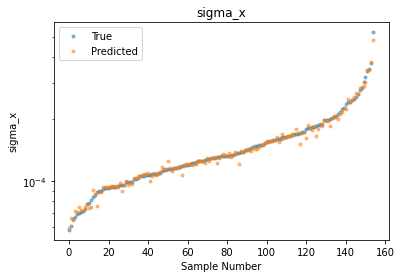

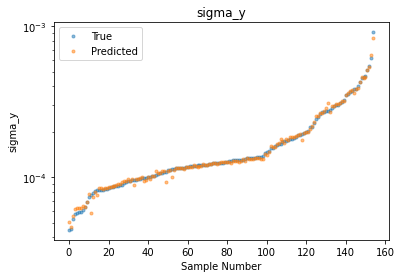

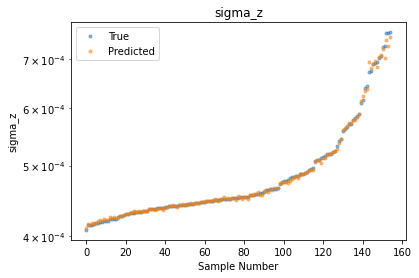

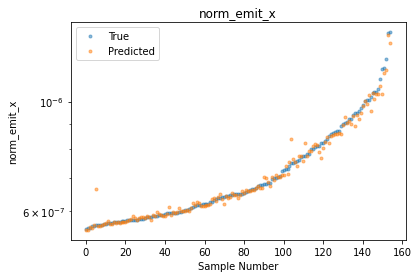

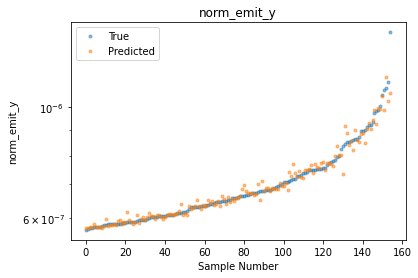

In [172]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(Model.model_out_list[i])
    plt.ylabel(Model.model_out_list[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted'])
    plt.show()

<a id="predict_machine"></a>
# Model Predict with Machine Unit Inputs

In [173]:
#Get some machine unit values by converting
X_true_pv = sim_to_machine(np.asarray(X_true))

In [174]:
Y_pred_pv = Model.pred_machine_units(X_true_pv);

In [175]:
Y_pred_sim = Model.pred_sim_units(X_true);

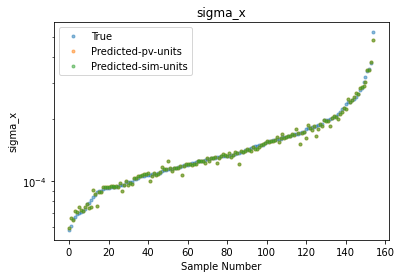

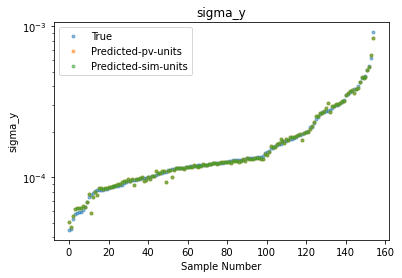

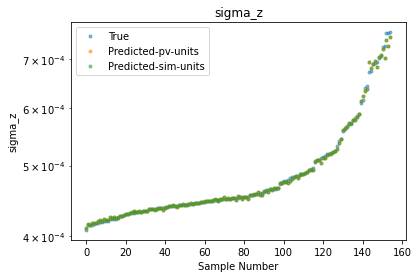

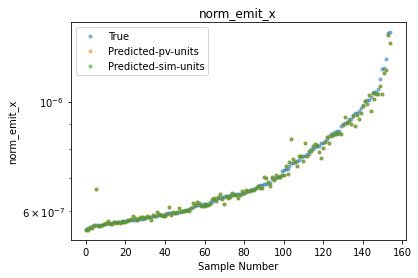

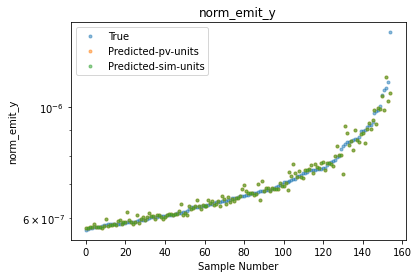

In [176]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred_pv[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred_sim[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(Model.model_out_list[i])
    plt.ylabel(Model.model_out_list[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted-pv-units','Predicted-sim-units'])
    plt.show()

### load some nominally optimal points from simulation to run

In [177]:
scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',]

#load from first scan
dat1 = json.load(open(PATH+scanlist[0]))
inputs=pd.DataFrame(dat1['inputs'])
outputs=pd.DataFrame(dat1['outputs'])

#select only model inputs and outputs
inputs = inputs[Model.model_in_list];

#for this run looking at slightly z in simulation, model will be off a bit
model_out_list2=['end_'+s for s in Model.model_out_list]

outputs = outputs[model_out_list2];

#select first row
ref_input_values = np.asarray(inputs[0:1])


In [178]:
# make predictions
Y_pred = Model.pred_sim_units(ref_input_values)

In [179]:
for out in model_out_list:
    print(out,' ', Y_pred[:,loc_out[out]])

sigma_x   [0.00050494]
sigma_y   [0.00083292]
sigma_z   [0.00045216]
norm_emit_x   [1.1734467e-06]
norm_emit_y   [1.1347943e-06]


### predict for some nominal running values of laser

In [180]:
#nominal values for 2/18/2021 measured
pv_lrad = 1.2 #mm
pv_pl = 2 #ps
# charge 250 pc
# bunch length  600um --> 2ps 

In [181]:
#convert to sim 
print(pv_lrad*pv_to_sim_factor['IRIS:LR20:130:CONFG_SEL'])
print(pv_pl*pv_to_sim_factor['Pulse_length'] )#no real PV for this

0.39999996
3.3


In [182]:
#copy nominal input values optimal from sim
md_values = pd.DataFrame.copy(inputs[0:1])

In [183]:
md_values[:][pv_to_sim_name['Pulse_length']] = pv_pl*pv_to_sim_factor['Pulse_length']
md_values[:][pv_to_sim_name['IRIS:LR20:130:CONFG_SEL']] = pv_lrad*pv_to_sim_factor['IRIS:LR20:130:CONFG_SEL']

In [184]:
# make predictions
# convert dataframe to array first
Y_pred = Model.pred_sim_units(np.asarray(md_values))

for out in model_out_list:
    print(out,' ', Y_pred[:,loc_out[out]])

sigma_x   [0.00050946]
sigma_y   [0.00083387]
sigma_z   [0.00046743]
norm_emit_x   [1.1716319e-06]
norm_emit_y   [1.1253212e-06]


In [185]:
md_values = np.asarray(md_values)



<a id="scan"></a>



# Compare with 1-D Scans from Simulation Around Optimum 
### (likely not well-sampled in training)

In [186]:
def do_scan(scan_var = 'SOL1:solenoid_field_scale',     
                scan_range =[0.23, 0.26],#[0.43, 0.46],
                ref_point = [[ 4.23867825e-01,
                              3.06083484e+00,
                              2.50000000e+02,
                              2.45806452e-01,
                              7.13917676e-04,
                              3.27285211e-04,
                              5.80000000e+07,
                              -9.53597349e+00,
                              7.00000000e+07,
                                9.85566222e+00]],
                units = 'sim',
                numscan = 100,
                Model = Model,
                plot = True,
                plot_keys = ['norm_emit_x']):

        x_scan = np.empty((numscan,len(Model.model_in_list)))

        x_scan[:,:] = np.asarray(ref_point)

        scan = np.linspace(scan_range[0],scan_range[1],numscan)

        x_scan[:, Model.loc_in[scan_var]] = scan

        if units == 'sim':
            Y_pred = Model.pred_sim_units(x_scan)

        #if units == 'machine':

         #   x_scan = machine_to_sim(x_scan)
         #   Y_pred = Model.pred_machine_units(x_scan)

        if plot:
            for key in plot_keys:
                plt.plot(x_scan[:,Model.loc_in[scan_var]],Y_pred[:,Model.loc_out[key]],'.')
                plt.ylabel(key)
                plt.xlabel(scan_var)
                plt.legend(['Neural Network Predictions'])
                plt.show()

        return x_scan, Y_pred


In [187]:
scanvar = 'SOL1:solenoid_field_scale'

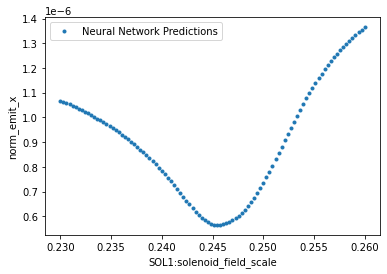

In [188]:
X_scan,Y_pred = do_scan(scanvar,scan_range =[0.23, 0.26]);

## Load some simulation scan data to compare with

In [189]:
sim_scanpath = '/gpfs/slac/staas/fs1/g/accelerator_modeling/edelen/LCLS_CU_full/sims/scan/'
sim_scan_idx={'SOL1:solenoid_field_scale':[0,32],'SQ01:b1_gradient':[32,64],'CQ01:b1_gradient':[64,96]}

sim_outputs = np.load(sim_scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

sim_inputs = np.load(sim_scanpath+'scan_scalar_in.npy',allow_pickle=True)

sim_inputs = pd.DataFrame(sim_inputs,columns=input_names)

sim_outputs = pd.DataFrame(sim_outputs,columns=output_names)

In [190]:
min_emit = 5.461418942827289e-07

### scan 'SOL1:solenoid_field_scale'

In [191]:
scanvar = 'SOL1:solenoid_field_scale'
scan_range_pv = [0.43/sim_to_pv_factor[scanvar], 0.5/sim_to_pv_factor[scanvar]]

In [192]:
#plt.plot(sim_inputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar],sim_outputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]]['norm_emit_x']*10**6,'.')
#plt.plot(X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar],Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
#plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
#plt.xlabel('Solenoid Field (kG*m)')
#plt.legend(['Simulation','Neural Network'])
#plt.ylim([min_emit*10**6,1])
#plt.show()

In [193]:
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv, plot = False );
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

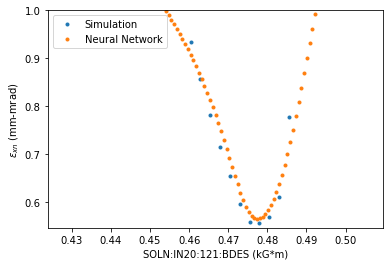

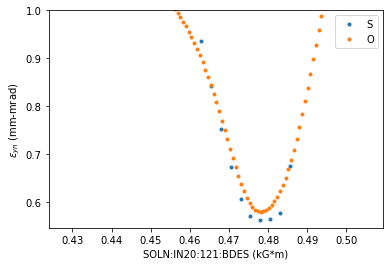

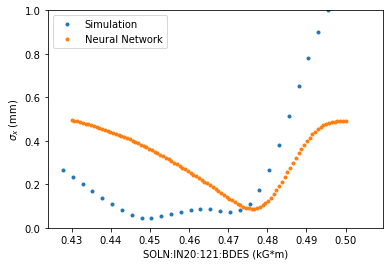

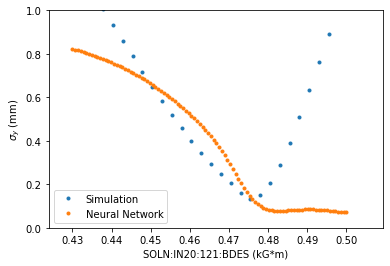

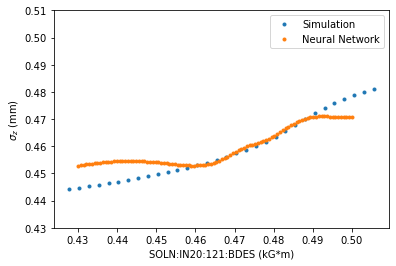

In [194]:
plot_multiple_comparison(scanvar,X_scan,Y_pred, X_data, Y_data, xlabel, leg = ['Simulation', 'Neural Network'] )

### scan 'SQ01:b1_gradient'

In [195]:
scanvar = 'SQ01:b1_gradient'
scan_range_pv = [-0.02/sim_to_pv_factor[scanvar], 0.02/sim_to_pv_factor[scanvar]]

In [196]:
#plt.plot(inputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar],outputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]]['norm_emit_y']*10**6,'.')
#plt.plot(X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar],Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
#plt.ylim([min_emit*10**6,1])
#plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
#plt.xlabel('SQ01 Skew Quad Gradient (kG)')
#plt.legend(['Simulation','Neural Network'])
#plt.show()

In [197]:
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv,plot=False );
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

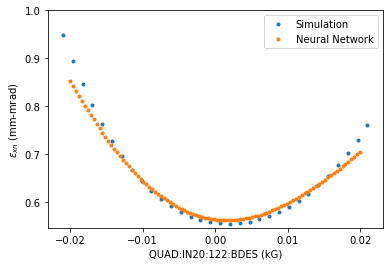

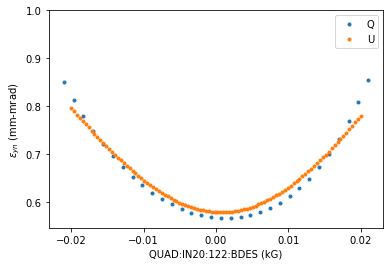

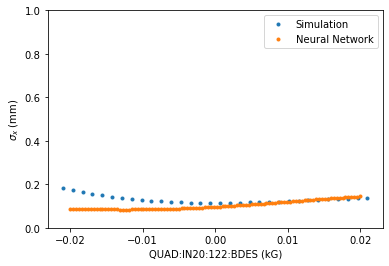

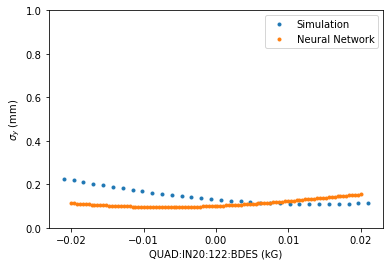

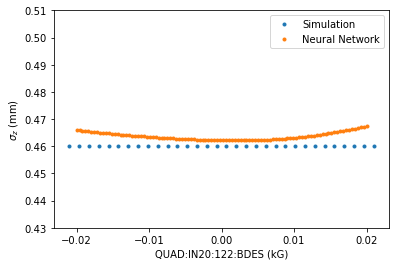

In [198]:
plot_multiple_comparison(scanvar,X_scan,Y_pred, X_data, Y_data, xlabel, leg = ['Simulation', 'Neural Network'] )

### scan 'CQ01:b1_gradient'

In [199]:
scanvar = 'CQ01:b1_gradient'
scan_range_pv = [-0.02/sim_to_pv_factor[scanvar], 0.02/sim_to_pv_factor[scanvar]]
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv,plot=False );

In [200]:
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv,plot=False );
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

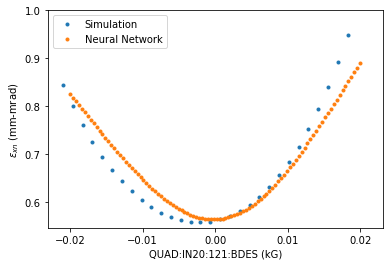

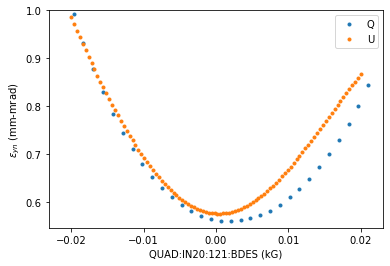

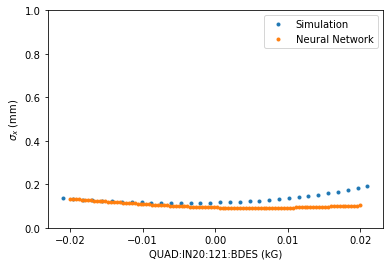

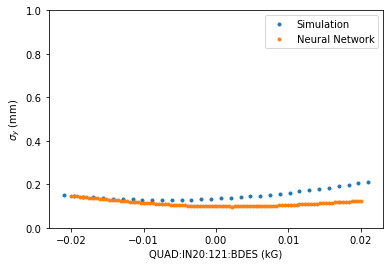

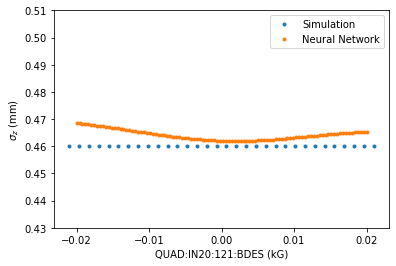

In [201]:
plot_multiple_comparison(scanvar,X_scan,Y_pred, X_data, Y_data, xlabel, leg = ['Simulation', 'Neural Network'] )

In [202]:
# do_scan_at_z16m(numscan=100, scanlist=[
#'scan_SOL1:solenoid_field_scale-fine2.json',
#'scan_SQ01:b1_gradient-fine2.json',
#'scan_CQ01:b1_gradient-fine2.json',])



<a id="meas"></a>


# Comparison with some measured data 
(note guessing on some of these inputs other than SQ/CQ/SOL, so not expected to be exact)

In [203]:
emitx = [1.4085,1.4305,1.0905, 0.7137,0.5358, 0.5075,0.6359,1.1666,2.4465]
emity = [2.5192, 1.7998, 0.6448, 0.6579, 0.5244, 0.5686, 0, 2.5051, 11.7213]

In [204]:
#CQ and SQ and SO
c=-0.0024
s=0
sol=np.asarray([0.440000000000000,0.445000000000000,
                0.450000000000000,0.455000000000000,
                0.460000000000000,0.465000000000000,
                0.470000000000000,0.475000000000000,0.480000000000000])

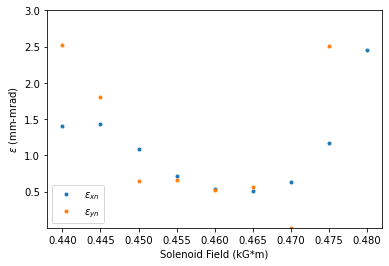

In [205]:
plt.plot(sol,emitx,'.')
plt.plot(sol,emity,'.')
plt.ylabel(r'$\epsilon$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([4e-7,3])
plt.legend([r'$\epsilon_{xn}$',r'$\epsilon_{yn}$ '])

In [206]:
# run NN scan
scanvar = 'SOL1:solenoid_field_scale'
scan_range_pv = [0.43/sim_to_pv_factor[scanvar], 0.56/sim_to_pv_factor[scanvar]]
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv,plot=False );
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]

In [207]:
# sim scan data
X_sim_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_sim_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]

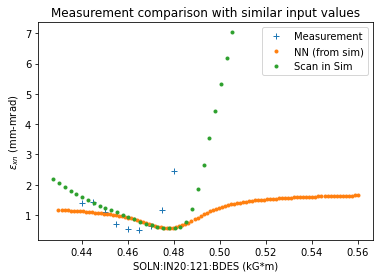

In [208]:
plt.plot(sol,emitx,'+')
plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(X_sim_data, Y_sim_data['norm_emit_x']*10**6,'.')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
#plt.ylim([0.35,1])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

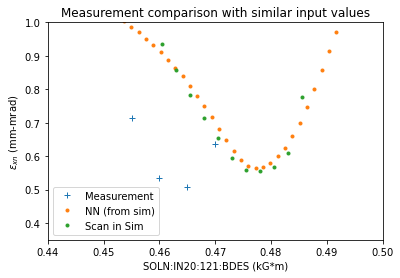

In [209]:
plt.plot(sol,emitx,'+')
plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(X_sim_data, Y_sim_data['norm_emit_x']*10**6,'.')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,1])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()

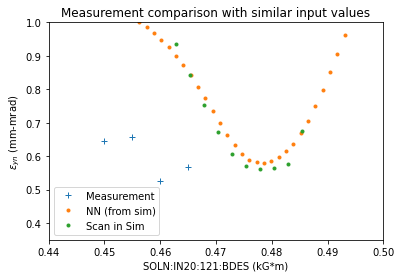

In [210]:
plt.plot(sol,emity,'+')
plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
plt.plot(X_sim_data, Y_sim_data['norm_emit_y']*10**6,'.')
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,1])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement comparison with similar input values")
plt.show()